In [1]:
%load_ext autoreload
%autoreload 2
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent))

In [2]:
%reload_ext dotenv

%dotenv ../../env/.env

import warnings
from pandas import Timedelta
# from optiml.utils import sf
import time
from optiml.utils.sf import logger, sql_to_df, run_sql, conn, session
import pandas as pd
warnings.filterwarnings('ignore')

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime


connected to account OMWYKHW-ENTERPRISE wh DEMO db SANDBOX schema PUBLIC with role DEV
time: 46 ms (started: 2023-06-08 01:30:45 -04:00)


In [3]:
# import uuid
# uuid = str(uuid.uuid4()).replace("-", "_")
# print(uuid)
# wh_name = f"test_{uuid}"

# create = f"""
# create or replace warehouse {wh_name}
# auto_suspend = 60
# SCALING_POLICY=STANDARD
# INITIALLY_SUSPENDED=true
# MAX_CLUSTER_COUNT = 4;
# """

# run_sql(create)

wh_name = 'test_bc9a9691_c770_4eb7_96e9_278aac7db0c6'
run_sql(f"use warehouse {wh_name}")


time: 548 ms (started: 2023-06-08 01:33:20 -04:00)


In [23]:
#    |-------------------------|------------------------------------------------------|
#   start                    60 sec

#    |--|                   |--|                                

#    |------|       |---------|    


#    |------|              |---------|


#    |-------------------------------|    

#    |------------------------------------------|      |-------|                |60sec
#                                                   S  R                        |S
#                                                                  S        
#                                                    ===        =================  
#    |-----------------------|     |---|
#   greedy after one minute:      SR                      S
# slightly less greedy                    S

import uuid


import sched , time

def print_time(a='default'):
    print("From print_time", time.time(), a)

def test_query(table_name, multiplier):
    # return f"""
    # create or replace table {table_name} as 
    # SELECT seq4() col1 , uniform(1, 10, RANDOM(12)) col2 
    # FROM TABLE(GENERATOR(ROWCOUNT => {multiplier} * 10000000)) v 
    # ORDER BY 2;
    # """
    return f"""
    create or replace table {table_name} as 
    with a as (
    SELECT seq4() col1 , uniform(1, 1000000000, RANDOM(12)) col2 
    FROM TABLE(GENERATOR(ROWCOUNT => {multiplier} * 10000000)) v
    )
    select a1.*, a2.col2 as col3
    from a a1
    left join a a2
    on a1.col1 = a2.col2
    ORDER BY a1.col2;
    """
import uuid
def run_query(multiplier, warehouse=None):
    print("running query")
    if warehouse:
        run_sql(f"use warehouse {warehouse};", wait=True)
    random_id = str(uuid.uuid4()).replace("-", "_")
    q = test_query(f"test_table_{random_id}", multiplier)
    run_sql(q, wait=False)

    
# def run_query(sec=10, warehouse=None):
#     print("running query")
#     if warehouse:
#         run_sql(f"use warehouse {warehouse};", wait=True)
#     run_sql(f"call test_query({sec});", wait=False)


    # PREPARE QUERY SCHEDULE

            #    |-------------------------|-------------------------|-------------------------|-------------------------|
            #   start                    60 sec

            #    |--|                   |--|                         |--|                   |--|

# Control        R                          S                   R                         S
# Test           R                                                                                                   S

initial_offset = 5

# QUERY_LENGTH = 10
NUM_PARALLEL_QUERIES = 10

workload_start_times = [0, 10, 20, 30] 


s = sched.scheduler(time.time, time.sleep)

for i in range(NUM_PARALLEL_QUERIES):
    for t in workload_start_times:
        offset = initial_offset + t
        # QUERY_WAIT = 0 if t < 30 else 10
        multiplier = t/5 + 1
        s.enter(offset,1,run_query,argument=(multiplier,))

for job in s.queue:
    print(job)


Event(time=1686202879.924106, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.924122, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.9241312, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.924138, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.924146, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.924154, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.9241621, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.92417, priority=1, action=<function run_query at 0x7f8e26d66d30>, argument=(1.0,), kwargs={})
Event(time=1686202879.924178, priority=1, action=<function run_

In [24]:
s.run()

running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
running query
time: 31.5 s (started: 2023-06-08 01:41:19 -04:00)


In [ ]:
run_sql(f"drop warehouse {wh_name}")

02:22:59 INFO:query: [drop warehouse test_248cb963_a182_4b59_9b2c_c82802ef6548]
02:22:59 INFO:query execution done


ProgrammingError: 002003 (02000): 01ac735e-0001-1d07-0000-0003f276b721: SQL compilation error:
Warehouse 'TEST_248CB963_A182_4B59_9B2C_C82802EF6548' does not exist or not authorized.

time: 333 ms (started: 2023-05-22 02:22:59 -04:00)


In [ ]:
qdf[['warehouse_name', 'cluster_number', 'start_time', 'exec_start_time', 'end_time', 'query_text', 'query_id']]

,warehouse_name,cluster_number,start_time,exec_start_time,end_time,query_text,query_id
0,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,1,2023-05-22 08:00:02.192000-07:00,2023-05-22 08:00:02.527000-07:00,2023-05-22 08:00:02.879000-07:00,select \n *\nfrom table(information_schema....,01ac7564-0001-1d07-0000-0003f276bca5
1,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,1,2023-05-22 07:59:45.030000-07:00,2023-05-22 07:59:45.688000-07:00,2023-05-22 07:59:45.923000-07:00,select \n *\nfrom table(information_schema....,01ac7563-0001-1d85-0000-0003f276c6fd
2,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,1,2023-05-22 07:56:39.544000-07:00,2023-05-22 07:56:39.677000-07:00,2023-05-22 07:56:39.949000-07:00,select \n *\nfrom table(information_schema....,01ac7560-0001-1dbf-0000-0003f276e33d
3,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,1,2023-05-22 07:56:10.554000-07:00,2023-05-22 07:56:11.474000-07:00,2023-05-22 07:56:12.426000-07:00,select \n *\nfrom table(information_schema....,01ac7560-0001-1dbf-0000-0003f276e339
4,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,1,2023-05-22 07:54:41.151000-07:00,2023-05-22 07:54:41.275000-07:00,2023-05-22 07:54:41.512000-07:00,select \n *\nfrom table(information_schema....,01ac755e-0001-1e2f-0000-0003f276d321
...,...,...,...,...,...,...,...
70,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,3,2023-05-22 07:29:34.434000-07:00,2023-05-22 07:29:34.945000-07:00,2023-05-22 07:32:40.399000-07:00,create or replace table test as SELECT seq4() ...,01ac7545-0001-1dbf-0000-0003f276e0b5
71,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,2,2023-05-22 07:29:34.235000-07:00,2023-05-22 07:29:34.406000-07:00,2023-05-22 07:33:00.168000-07:00,call test_query(10);,01ac7545-0001-1d85-0000-0003f276c43d
72,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,2,2023-05-22 07:29:33.810000-07:00,2023-05-22 07:29:34.023000-07:00,2023-05-22 07:32:59.902000-07:00,call test_query(10);,01ac7545-0001-1dbf-0000-0003f276e0a9
73,TEST_1C01F24E_3523_47E8_97B2_1C3759C0ED0E,4,2023-05-22 07:29:33.349000-07:00,2023-05-22 07:29:34.693000-07:00,2023-05-22 07:32:40.363000-07:00,create or replace table test as SELECT seq4() ...,01ac7545-0001-1dbf-0000-0003f276e0a1


time: 731 ms (started: 2023-05-22 11:59:01 -04:00)


In [18]:
print(queries)


with q as (
select 
    *,
      warehouse_name || ':' || cluster_number || ':' || query_id as warehouse_query,
    TIMESTAMPADD( millisecond , -execution_time,end_time) as exec_start_time
from table(information_schema.query_history_by_warehouse('test_bc9a9691_c770_4eb7_96e9_278aac7db0c6'))
where execution_status != 'RUNNING'
and warehouse_size is not null
order by start_time desc
limit 100
)
select
  'running' as status,
  warehouse_query,
  warehouse_name,
  cluster_number,
  exec_start_time as start_time,
  end_time,
  query_text,
  query_id
from q
union
select
  'queued' as status,
  warehouse_query,
  warehouse_name,
  cluster_number,
  start_time,
  exec_start_time as end_time,
  query_text,
  query_id
from q

time: 7 ms (started: 2023-06-01 13:21:26 -04:00)


In [20]:
import plotly.express as px

queries = f"""
with q as (
select 
    *,
      warehouse_name || ':' || cluster_number || ':' || query_id as warehouse_query,
    TIMESTAMPADD( millisecond , -execution_time,end_time) as exec_start_time
from table(information_schema.query_history_by_warehouse('{wh_name}'))
where execution_status != 'RUNNING'
and warehouse_size is not null
and start_time between '2023-06-01 21:30' and '2023-06-02 11:00'
order by start_time desc
limit 100
)
select
  'running' as status,
  warehouse_query,
  warehouse_name,
  cluster_number,
  exec_start_time as start_time,
  end_time,
  query_text,
  query_id
from q
union
select
  'queued' as status,
  warehouse_query,
  warehouse_name,
  cluster_number,
  start_time,
  exec_start_time as end_time,
  query_text,
  query_id
from q
"""

qdf = sql_to_df(queries)
display(qdf)

,status,warehouse_query,warehouse_name,cluster_number,start_time,end_time,query_text,query_id
0,running,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:4:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,4,2023-06-01 21:34:52.171000-07:00,2023-06-01 21:36:59.004000-07:00,create or replace table test_table_0d21fbeb_80...,01acb0d2-0001-2143-0003-f2760001dc56
1,running,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:4:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,4,2023-06-01 21:34:51.991000-07:00,2023-06-01 21:36:57.199000-07:00,create or replace table test_table_efe7d243_80...,01acb0d2-0001-217d-0003-f2760001fd02
2,running,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:4:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,4,2023-06-01 21:34:52.434000-07:00,2023-06-01 21:36:59.118000-07:00,create or replace table test_table_b633ef7f_86...,01acb0d2-0001-2143-0003-f2760001dc52
3,running,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:4:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,4,2023-06-01 21:34:51.882000-07:00,2023-06-01 21:36:39.839000-07:00,create or replace table test_table_38c756d4_f0...,01acb0d2-0001-217d-0003-f2760001fcfe
4,running,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:1:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,1,2023-06-01 21:34:52.346000-07:00,2023-06-01 21:38:00.630000-07:00,create or replace table test_table_9dedac9e_6b...,01acb0d2-0001-217d-0003-f2760001fcfa
...,...,...,...,...,...,...,...,...
75,queued,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:1:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,1,2023-06-01 21:34:02.327000-07:00,2023-06-01 21:34:02.566000-07:00,create or replace table test_table_2a8d6832_47...,01acb0d2-0001-217d-0003-f2760001fc8a
76,queued,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:1:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,1,2023-06-01 21:34:02.202000-07:00,2023-06-01 21:34:02.548000-07:00,create or replace table test_table_790c260b_e7...,01acb0d2-0001-2143-0003-f2760001dbee
77,queued,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:1:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,1,2023-06-01 21:34:02.081000-07:00,2023-06-01 21:34:02.406000-07:00,create or replace table test_table_5220e3e9_5a...,01acb0d2-0001-217d-0003-f2760001fc82
78,queued,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6:2:01...,TEST_BC9A9691_C770_4EB7_96E9_278AAC7DB0C6,2,2023-06-01 21:34:11.475000-07:00,2023-06-01 21:34:11.957000-07:00,create or replace table test_table_f1c50db1_d8...,01acb0d2-0001-217d-0003-f2760001fc9e


time: 568 ms (started: 2023-06-08 01:39:13 -04:00)


In [21]:
[qdf.start_time.min(),qdf.end_time.max()]

[Timestamp('2023-06-01 21:34:01.611000-0700', tz='America/Los_Angeles'),
 Timestamp('2023-06-01 21:38:00.630000-0700', tz='America/Los_Angeles')]

time: 2.76 ms (started: 2023-06-08 01:39:15 -04:00)


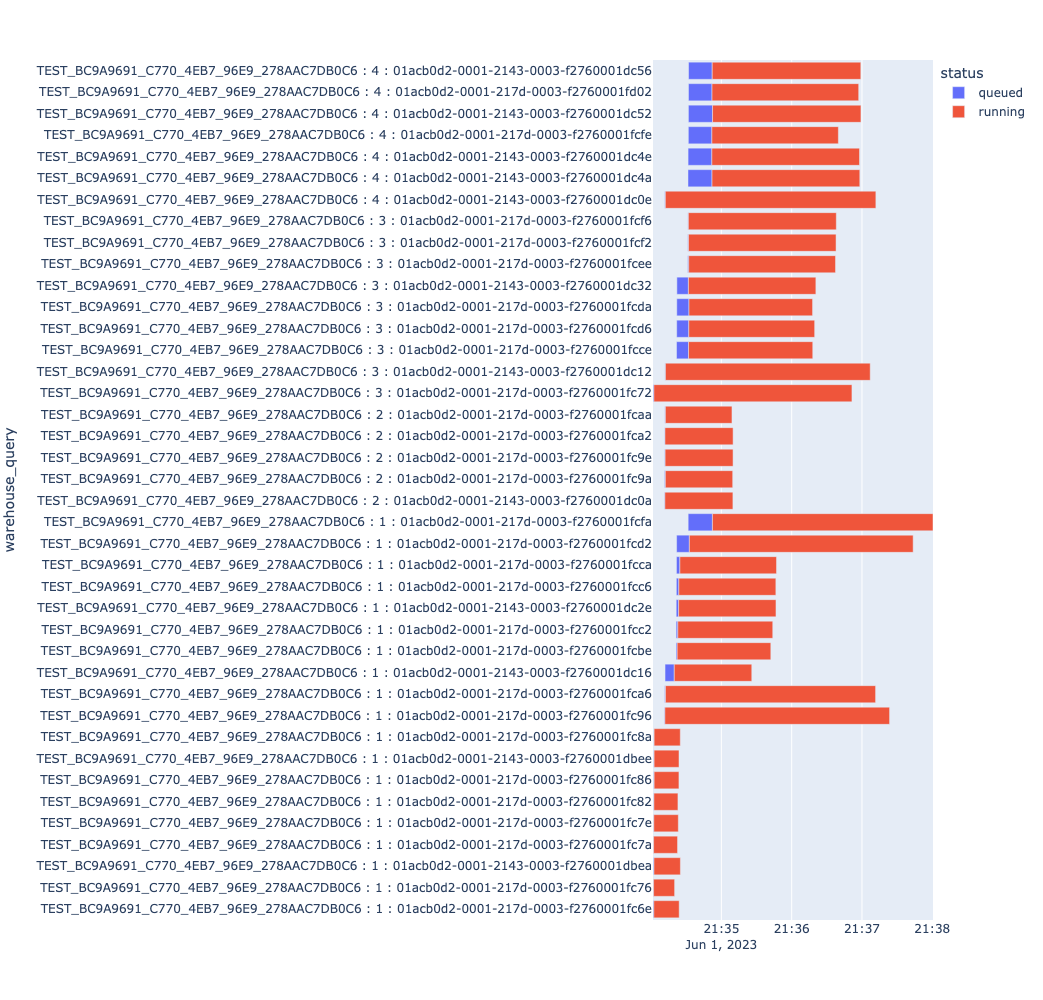

time: 60.1 ms (started: 2023-06-08 01:39:16 -04:00)


In [22]:
import plotly.express as px



qdf['warehouse_query'] = qdf.warehouse_name + " : " + qdf.cluster_number.map(str) + " : " + qdf.query_id

fig = px.timeline(qdf.sort_values(['warehouse_name', 'cluster_number', 'start_time']), 
                  x_start="start_time", x_end="end_time", y="warehouse_query", 
                  color='status', 
                  hover_data=['query_text', 'query_id'])

fig.update_layout(
    height=1000,
)
fig.update_xaxes(range = [qdf.start_time.min(),qdf.end_time.max()])

fig.show()


# figures = [
#         px.scatter(whe.sort_values('warehouse_name'), x="timestamp", y="warehouse_name", color='event_name'),
#         px.timeline(qdf.sort_values(['warehouse_name', 'start_time']), x_start="start_time", x_end="end_time", y="warehouse_query", hover_data=['query_text', 'query_id']),
#     ]

# fig = make_subplots(rows=len(figures), cols=1, shared_xaxes=True, vertical_spacing=0.05) 

# for i, figure in enumerate(figures):
#     for trace in range(len(figure["data"])):
#         fig.append_trace(figure["data"][trace], row=i+1, col=1)

# fig.update_xaxes(title_text="warehouse events", row=1, col=1)
# fig.update_xaxes(title_text="queries", row=2, col=1)
# fig.update_xaxes(showgrid=True,minor=dict(showgrid=True))
# fig.update_yaxes(showgrid=True,minor=dict(showgrid=True))
# fig.update_xaxes(autorange=True)
# fig.update_layout(
#     height=800,
# )
# fig.update_xaxes(type='date', autorange=True)

# fig.show()

# fig = px.bar(whm[whm.warehouse_name != 'OPS'], y='warehouse_name', x = ['credits_used_compute'], orientation = 'h', title='credits x warehouse')
# fig.show()
# fig = px.bar(whm, y='warehouse_name', x = ['credits_used_compute', 'credits_used_cloud_services'], orientation = 'h')
# fig.show()

In [34]:
qdf.query_id.nunique()

66

time: 5.76 ms (started: 2023-06-01 20:35:26 -04:00)


In [ ]:

from optiml.utils.sf import snowconn

 
def monitor(target_wh, using_wh, continuous=False):
    using_conn = snowconn()
    
    def show():
        run_sql(f"USE WAREHOUSE {using_wh}", ctx=using_conn)
        show_df = sql_to_df("show warehouses")

        queries = f"""
        select 
        *
    from table(information_schema.query_history_by_warehouse('{target_wh}'))
    order by start_time desc
    limit 10;
        """
        show_df = sql_to_df("show warehouses")
        print(show_df[show_df.name == target_wh.upper()].to_string())

        queries_df = sql_to_df(queries)
        print(show_df[show_df.name == target_wh.upper()].to_string())
        print(queries_df.to_string())
    
    show()
    # if continuous:
    #     while(True):
            

monitor("test", "demo")

11:52:35 INFO:Snowflake Connector for Python Version: 2.7.12, Python Version: 3.8.16, Platform: macOS-10.15.7-x86_64-i386-64bit
11:52:35 INFO:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
11:52:35 INFO:closed
11:52:35 INFO:No async queries seem to be running, deleting session
11:52:37 INFO:closed
11:52:37 INFO:No async queries seem to be running, deleting session
11:52:37 INFO:closed
11:52:37 INFO:No async queries seem to be running, deleting session
11:52:38 INFO:query: [USE WAREHOUSE demo]


connected to account OMWYKHW-ENTERPRISE wh DEMO db SANDBOX schema PUBLIC with role DEV


11:52:39 INFO:query execution done
11:52:39 INFO:query: [show warehouses]
11:52:39 INFO:query execution done
11:52:39 INFO:query: [show warehouses]
11:52:39 INFO:query execution done
11:52:39 INFO:query: [select * from table(information_schema.query_history_by_warehouse('test')) order...]


   name      state      type     size  min_cluster_count  max_cluster_count  started_clusters  running  queued is_default is_current  auto_suspend auto_resume available provisioning quiescing other                       created_on                       resumed_on                       updated_on owner comment enable_query_acceleration  query_acceleration_max_scale_factor resource_monitor  actives  pendings  failed  suspended      uuid scaling_policy
1  TEST  SUSPENDED  STANDARD  X-Small                  1                  2                 0        0       0          N          N            60        true                                        2023-05-18 22:52:29.350000+00:00 2023-05-21 21:35:10.232000+00:00 2023-05-21 21:35:10.232000+00:00   DEV                             false                                    8             null        0         0       0          1  66221584       STANDARD
using arrow to fetch results...


11:52:40 INFO:query execution done


   name      state      type     size  min_cluster_count  max_cluster_count  started_clusters  running  queued is_default is_current  auto_suspend auto_resume available provisioning quiescing other                       created_on                       resumed_on                       updated_on owner comment enable_query_acceleration  query_acceleration_max_scale_factor resource_monitor  actives  pendings  failed  suspended      uuid scaling_policy
1  TEST  SUSPENDED  STANDARD  X-Small                  1                  2                 0        0       0          N          N            60        true                                        2023-05-18 22:52:29.350000+00:00 2023-05-21 21:35:10.232000+00:00 2023-05-21 21:35:10.232000+00:00   DEV                             false                                    8             null        0         0       0          1  66221584       STANDARD
                               query_id                                                     